# Build surface water bodies suitablity layers for GRIDCERF


The following code was used to build the surface water bodies suitability layers for GRIDCERF. GRIDCERF does not provide the source data directly due to some license restrictions related for direct redistribution of the unaltered source data.  However, the following details the provenance associated with each source dataset and how they were processed.

## 1. Setup environment

### 1.1 Download GRIDCERF

Download the GRIDCERF package if you have not yet done so from here:  https://doi.org/10.5281/zenodo.6601789.  Please extract GRIDCERF inside the `data` directory of this repository as the paths in this notebook are set to that expectation.


### 1.2 Data description


- **Title**:  North America Rivers and Lakes
- **Description from Source**: The North American Atlas - Hydrography data set shows the coastline, linear hydrographic features, and area hydrographic features in North America.
- **Source URL**:  https://www.sciencebase.gov/catalog/item/4fb55df0e4b04cb937751e02
- **Date Accessed**:  09/26/23
- **Citation**
> US Geological Survey, 2017. North America Rivers and Lakes. North America Spatial Data. https://www.sciencebase.gov/catalog/item/4f4e4760e4b07f02db47df9c
- **Application**: To avoid siting technologies on water bodies, locations of lakes within the CONUS are excluded. The North American Rivers and Lakes dataset includes both natural lakes (Type 16 in the dataset) and reservoirs (Type 18 in the dataset). Other data item types represent land, ocean, or N/A areas and are not included in the final suitability layer.


### 1.3 Import modules


In [1]:
import os

import geopandas as gpd
import numpy as np
import rasterio
from rasterio import features

## 2. Configuration


In [2]:
# get the parent directory path to where this notebook is currently stored
root_dir = os.path.dirname(os.getcwd())

# data directory in repository
data_dir = os.path.join(root_dir, "data")

# GRIDCERF data directory from downloaded archive
gridcerf_dir = os.path.join(data_dir, "gridcerf")

# GRIDCERF reference data directory
reference_dir = os.path.join(gridcerf_dir, "reference")

# GRIDCERF source data directory for the downloaded data
source_dir = os.path.join(gridcerf_dir, "source", "technology_specific",  'surface_water_bodies' )

# GRIDCERF technology_specific data directory
technology_specific_dir = os.path.join(gridcerf_dir, "technology_specific")

# GRIDCERF common data directory
common_dir = os.path.join(gridcerf_dir, "common")

# GRIDCERF compiled final suitability data directory
compiled_dir = os.path.join(gridcerf_dir, "compiled")

# template siting mask raster
template_raster = os.path.join(reference_dir, "gridcerf_sitingmask.tif")

# template conus mask raster
land_mask_raster = os.path.join(reference_dir, "gridcerf_landmask.tif")

# template conus mask raster
conus_mask = os.path.join(reference_dir, "gridcerf_landmask.tif")

# CONUS boundary shapefile
conus_shpfile = os.path.join(reference_dir, "gridcerf_conus_boundary.shp")

# shapefile location for the source airports
lake_shpfile = os.path.join(source_dir, 'NA_Lakes_and_Rivers', 'data',  "hydrography_p_lakes_v2.shp")

# output rasters
output_lake_file = os.path.join(common_dir, "gridcerf_usgs_lakes_reservoirs.tif")

# factor for converting a mile to meter
mi_to_meter = 1609.34

# crs for converting projections
crs = 'ESRI:102003'


## 4. Generate suitability rasters

### 4.1 Functions to build suitability

In [3]:
def vector_to_raster(template_raster, land_mask_raster, gdf, value_field, output_raster):
                     
    # open the template raster and extract metadata and land mask
    with rasterio.open(template_raster) as template:

        metadata = template.meta.copy()

        # update raster data type
        metadata.update(dtype=np.int16)

        # extract land mask
        land_mask_file = rasterio.open(land_mask_raster)
        land_mask = land_mask_file.read(1)
        land_mask = np.where(land_mask == 0, np.nan, 1)

        # write output raster
        with rasterio.open(output_raster, 'w+', **metadata) as out:

            out_arr = out.read(1)

            # build shapes to rasterize from target geometry and field
            shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf[value_field]))

            # burn features
            burned = features.rasterize(shapes=shapes, 
                                        fill=0, 
                                        out=out_arr, 
                                        transform=out.transform)
            
            burned = np.where(burned == 1, 1, 0).astype(np.float64)
            
            # apply land mask
            burned *= land_mask
            
            # make nan excluded
            burned = np.where(np.isnan(burned), 1, burned)

            out.write_band(1, burned.astype(np.int16))


### 4.2 Generate suitability

In [4]:
# read in GRIDCERF boundary shapefile
bdf = gpd.read_file(conus_shpfile)

<Axes: >

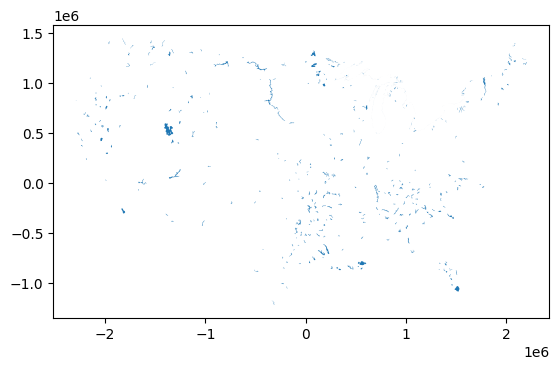

In [5]:
# read in shapefile and project to our GRIDCERF projection
gdf = gpd.read_file(lake_shpfile).to_crs(crs=crs)

# only keep areas within our GRIDCERF boundary
gdf = gpd.clip(gdf, bdf)

# keep only lakes and reservoirs
gdf = gdf[gdf.TYPE.isin([16,18])]

# add field to use for rasterization
gdf["value"] = 1

gdf.plot()

In [6]:
# generate raster
vector_to_raster(template_raster=template_raster, 
                 land_mask_raster=template_raster,
                 gdf=gdf, 
                 value_field="value",
                 output_raster=output_lake_file)